<a href="https://colab.research.google.com/github/tutorials101/micrograd/blob/main/micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<> Micrograd Engine Re-Implementation; I'm gonna call it **Scalargrad** instead. You may ask why? I mean why not...? lol

This is my effort to learn and improve my knowledge and skills

ref: https://youtu.be/VMj-3S1tku0?si=yOYgVsaueCvW9oDB

**Logs**: Bugs that I came across while building the engine

*   Forgot to accumulate gradients for some operation; did "grad =" instead of "grad += "
*   Stupid mistake, insted of out node, I assigned the backprop function to self node. Don't ask me why! It was chatgpt who found the error..
* Also learned how \__r*__(self, other) function works, For eg, for \__rsub__(self, other) called for constant - ScalarObject, where self=ScalarObject and other=constant; now to actually do the operation, you should do -self + constant
* I tried lr=0.1 with ReLU, and I observed that there was no gradient updates and the loss remained at 4.XX something. When I tried lr=0.01, it converges but sometimes the loss kinda get stuck at 4.XX. Most probably due to dead relus. So lr is really important guys! But with lr=0.001, things works!




In [1]:
# computational graph visualization
from graphviz import Digraph

def trace(node):

  nodes, edges = set(), set()

  def parse(node):
    if node not in nodes:
      nodes.add(node)

    for parent in node.parents:
      if (parent, node) not in edges:
        edges.add((parent, node))
      parse(parent)

  parse(node)

  return nodes, edges

def draw_graph(node):

  dot = Digraph(graph_attr={'rankdir':'LR'})
  nodes, edges = trace(node)

  for node in nodes:
    if node.label:
      dot.node(name=str(id(node)), label="{ %s | data=%.2f | grad=%.2f }" % (node.label, node.data, node.grad), shape='record')
    else:
      dot.node(name=str(id(node)), label="{data=%.2f | grad=%.2f }" % (node.data, node.grad), shape='record')
    if node.operator:
      dot.node(name=str(id(node))+node.operator, label=node.operator)
      dot.edge(str(id(node))+node.operator, str(id(node)))


  for (node1, node2) in edges:
    dot.edge(str(id(node1)), str(id(node2))+node2.operator)


  return dot





In [2]:
# building blocks

import math

class Scalar:

  def __init__(self, data, parents=(), operator='', label=''):
    self.data = data
    self.grad = 0.0
    self.parents = parents
    self.operator = operator
    self.label = label
    self.backprop = lambda: None

  def __repr__(self):
    return f"Scalar(data={self.data}, grad={self.grad})"

  #scalar operations
  def __add__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = Scalar(self.data + other.data, parents=(self, other), operator='+')

    def backprop():
      self.grad += out.grad
      other.grad += out.grad
    out.backprop = backprop

    return out

  def __radd__(self, other):
    return self + other

  def __neg__(self):
    return self * -1

  def __sub__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    return self + (-other)

  def __rsub__(self, other): # other - self
    return (-self) + other


  def __mul__(self, other):

    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = Scalar(self.data*other.data, parents=(self, other), operator='*')

    def backprop():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out.backprop = backprop

    return out

  def __rmul__(self, other):
    return self * other

  def exp(self):
    out = Scalar(math.exp(self.data), parents=(self,), operator='exp')

    def backprop():
      self.grad += out.data * out.grad
    out.backprop = backprop

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only support int or float exponents"
    out = Scalar(self.data**other, parents=(self,), operator=f"^{other}")

    def backprop():
      self.grad += (other * self.data**(other-1))*out.grad

    out.backprop = backprop

    return out

  def __truediv__(self, other):
    if not isinstance(other, Scalar):
      other = Scalar(other)
    out = self * (other**-1)

    return out

  def __rtruediv__(self, other):
    return (self**-1) * other

  def tanh(self):
    out = Scalar(math.tanh(self.data), parents=(self,), operator='tanh')

    def backprop():
      self.grad += (1-out.data**2) * out.grad
    out.backprop = backprop

    return out

  def relu(self):
    out = Scalar(max(self.data, 0), parents=(self,), operator='relu')

    def backprop():
      self.grad += (out.data>0) * out.grad

    out.backprop = backprop

    return out

  def backward(self):

    sorted_nodes = []
    visited_nodes = set()
    def sort_node(node):
      if node not in visited_nodes:
        visited_nodes.add(node)
        for parent in node.parents:
          sort_node(parent)
        sorted_nodes.append(node)
    sort_node(self)

    self.grad = 1.0
    for node in reversed(sorted_nodes):
      node.backprop()




In [3]:
# Sanity check - ref: https://github.com/karpathy/micrograd/blob/master/test/test_engine.py

In [4]:
import torch

def test_sanity_check():

    x = Scalar(-4.0)
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xmg, ymg = x, y

    x = torch.Tensor([-4.0]).double()
    x.requires_grad = True
    z = 2 * x + 2 + x
    q = z.relu() + z * x
    h = (z * z).relu()
    y = h + q + q * x
    y.backward()
    xpt, ypt = x, y

    # forward pass went well
    assert ymg.data == ypt.data.item()
    # backward pass went well
    assert xmg.grad == xpt.grad.item()

def test_more_ops():

    a = Scalar(-4.0)
    b = Scalar(2.0)
    c = a + b
    d = a * b + b**3
    c += c + 1
    c += 1 + c + (-a)
    d += d * 2 + (b + a).relu()
    d += 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g += 10.0 / f
    g.backward()
    amg, bmg, gmg = a, b, g

    a = torch.Tensor([-4.0]).double()
    b = torch.Tensor([2.0]).double()
    a.requires_grad = True
    b.requires_grad = True
    c = a + b
    d = a * b + b**3
    c = c + c + 1
    c = c + 1 + c + (-a)
    d = d + d * 2 + (b + a).relu()
    d = d + 3 * d + (b - a).relu()
    e = c - d
    f = e**2
    g = f / 2.0
    g = g + 10.0 / f
    g.backward()
    apt, bpt, gpt = a, b, g

    tol = 1e-6
    # forward pass went well
    assert abs(gmg.data - gpt.data.item()) < tol
    # backward pass went well
    assert abs(amg.grad - apt.grad.item()) < tol
    assert abs(bmg.grad - bpt.grad.item()) < tol

test_sanity_check()
test_more_ops()

In [5]:
x = Scalar(-4.0, label='x')
z = 2 * x + 2 + x
z.label='z'
q = z.relu() + z * x
q.label='q'
h = (z * z).relu()
h.label='h'
y = h + q + q * x
y.label='y'
y.backward()


# display(draw_graph(y))

print(x.grad, z.grad, q.grad, h.grad, y.grad)

xmg, ymg = x, y

x = torch.Tensor([-4.0]).double()
x.requires_grad = True
z = (2 * x + 2 + x)
z.retain_grad()


q = (z.relu() + z * x)
q.retain_grad()
h = ((z * z).relu())
h.retain_grad()
y = h + q + q * x
y.retain_grad()
y.backward()
xpt, ypt = x, y

print(x.grad.item(), z.grad.item(), q.grad.item(), h.grad.item(), y.grad.item())


46.0 -8.0 -3.0 1.0 1.0
46.0 -8.0 -3.0 1.0 1.0


In [6]:
#tutorial sanity check

x1 = Scalar(2.0, label='x1')
x2 = Scalar(0.0, label='x2')
w1 = Scalar(-3.0, label='w1')
w2 = Scalar(1.0, label='w2')

b = Scalar(6.8813735870195432, label='b')
x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1+x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e-1)/(e+1)

o.label='o'
o.backward()
# draw_graph(o)

<> Neurons, Layers, MLP

In [7]:
import numpy as np

class Neuron:

  def __init__(self, in_dim):

    self.w = [Scalar(np.random.uniform()) for i in range(in_dim)]
    self.b = Scalar(np.random.uniform())

  def __call__(self, x):

    out = sum([xi * wi for xi,wi in zip(x, self.w)]+[self.b])
    return out

  def parameters(self):
    return self.w + [self.b]

# Activation Functions
def relu(x):
  assert isinstance(x,Scalar), "input should be a Scalar instance"
  return x.relu()

def tanh(x):
  assert isinstance(x,Scalar), "input should be a Scalar instance"
  return x.tanh()

class Layer: #collection of neurons

  def __init__(self, in_dim, out_dim, activation_fn = None):
    self.in_dim=in_dim
    self.out_dim = out_dim

    self.neurons = [Neuron(in_dim) for _ in range(out_dim)]
    self.activation_fn = activation_fn

  def __call__(self, x):
    outs = [neuron(x) for neuron in self.neurons]
    outs = [self.activation_fn(out) for out in outs] if self.activation_fn else outs
    return outs[0] if len(outs)==1 else outs

  def parameters(self):
    params = []
    for neuron in self.neurons:
      params += neuron.parameters()

    return params

  def __repr__(self):
    return f"Linear(in_dim={self.in_dim}, # neurons={self.out_dim})" + (f", {self.activation_fn.__name__}" if self.activation_fn else "")

class MLP:

  def __init__(self, layers, activation_fn):

    self.layers = []

    in_dim = layers[0]

    for out_dim in layers[1:-1]:
      self.layers.append(Layer(in_dim, out_dim, activation_fn))
      in_dim = out_dim

    out_dim = layers[-1]
    self.layers.append(Layer(in_dim, out_dim))

  def __repr__(self):

    return "MLP"+str(self.layers)

  def __call__(self, x):

    for layer in self.layers:
      x = layer(x)

    return x

  def parameters(self):
    params = []
    for layer in self.layers:
      params += layer.parameters()
    return params

  def zero_grad(self):
    for p in self.parameters():
      p.grad = 0.0


<> Andrej Video Tutorial Example

In [8]:
activation_fn = relu


nn = MLP([3,4,4,1], activation_fn=activation_fn)
print(nn)

x = [2.0, 3.0, -1.0]
out = nn(x)
out

MLP[Linear(in_dim=3, # neurons=4), relu, Linear(in_dim=4, # neurons=4), relu, Linear(in_dim=4, # neurons=1)]


Scalar(data=19.28749133871249, grad=0.0)

In [9]:
# draw_graph(out)

In [10]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]


def optimize(net, xs, ys, num_epochs=1500):

  for i in range(num_epochs):

    net.zero_grad()

    ypreds = [net(x) for x in xs]

    loss = sum([(ypred-y)**2 for ypred,y in zip(ypreds, ys)])
    loss.backward()

    for p in net.parameters():
      p.data -= 0.001 * p.grad

    # display(draw_graph(loss))

    print(f"epoch-{i}: loss={loss.data}")


optimize(nn, xs, ys)


epoch-0: loss=700.3632782857583
epoch-1: loss=11.504745135131628
epoch-2: loss=7.6275859689805925
epoch-3: loss=6.225604919835059
epoch-4: loss=5.677610224303446
epoch-5: loss=5.444815395468248
epoch-6: loss=5.332111986983104
epoch-7: loss=5.266167834643166
epoch-8: loss=5.218919246699651
epoch-9: loss=5.179513492441283
epoch-10: loss=5.143717445063498
epoch-11: loss=5.109861018300893
epoch-12: loss=5.077271056393777
epoch-13: loss=5.045663787677017
epoch-14: loss=5.014908373337441
epoch-15: loss=4.984934656800167
epoch-16: loss=4.955697090802271
epoch-17: loss=4.927160590792168
epoch-18: loss=4.8992949580584675
epoch-19: loss=4.872072655963881
epoch-20: loss=4.845467899693524
epoch-21: loss=4.819456261622857
epoch-22: loss=4.794014480145547
epoch-23: loss=4.769120349885826
epoch-24: loss=4.744752645584928
epoch-25: loss=4.7208910610103985
epoch-26: loss=4.6975161555660705
epoch-27: loss=4.674609305680534
epoch-28: loss=4.652152659752195
epoch-29: loss=4.630129096082323
epoch-30: loss=

In [11]:
ypreds = [nn(x) for x in xs]
ypreds

[Scalar(data=1.0130169248211442, grad=0.0),
 Scalar(data=-0.9969801600521062, grad=0.0),
 Scalar(data=-1.0059456783048384, grad=0.0),
 Scalar(data=0.9774079801565351, grad=0.0)]

<> Moon Data

In [12]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import random
import numpy as np

In [13]:
X,y = make_moons(n_samples=100, noise=0.1)
y[y==0] = -1 # to make sure that y is either 1 or -1

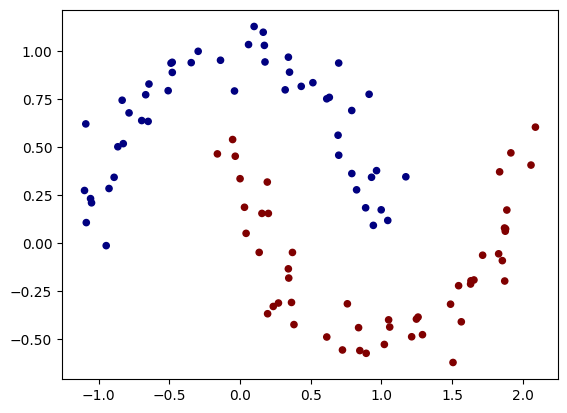

In [14]:
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [15]:
#MLP with svm loss

In [102]:
def svm_loss(scores, ys):

  return sum([(1 + yi * -scorei).relu() for (yi, scorei) in zip(ys, scores)])/len(scores)

def fit(net, X, y, lr=1e-1, l2=1e-4, num_iter=500, batch_size=None):

  for i in range(num_iter):

    net.zero_grad()

    Xb, yb = X, y
    if batch_size:
      idx = np.random.permutation(len(X))[:batch_size]
      Xb = X[idx]
      yb = y[idx]

    scoreb = list(map(net, Xb))

    loss = svm_loss(scoreb, yb) + l2 * sum([p*p for p in net.parameters()])
    loss.backward()

    for p in net.parameters():
      p.data -= lr * p.grad

    acc = sum([(scorei.data>0)==(yi>0) for (scorei, yi) in zip(scoreb, yb)])/len(scoreb)
    print(f"epoch-{i}: loss={loss.data:0.4f}, acc={acc*100}%")





In [103]:
net = MLP([2, 16, 16, 1], activation_fn=relu)
print(net)
batch_size = None
fit(net, X, y, num_iter=500, lr=1e-1)

MLP[Linear(in_dim=2, # neurons=16), relu, Linear(in_dim=16, # neurons=16), relu, Linear(in_dim=16, # neurons=1)]
epoch-0: loss=32.3665, acc=50.0%
epoch-1: loss=4.6762, acc=50.0%
epoch-2: loss=11.1832, acc=50.0%
epoch-3: loss=6.6171, acc=50.0%
epoch-4: loss=3.0790, acc=50.0%
epoch-5: loss=6.5006, acc=50.0%
epoch-6: loss=0.7346, acc=71.0%
epoch-7: loss=2.6877, acc=50.0%
epoch-8: loss=3.8854, acc=50.0%
epoch-9: loss=0.6615, acc=77.0%
epoch-10: loss=1.9517, acc=50.0%
epoch-11: loss=1.7857, acc=50.0%
epoch-12: loss=2.2797, acc=50.0%
epoch-13: loss=0.5819, acc=79.0%
epoch-14: loss=1.7387, acc=50.0%
epoch-15: loss=0.6453, acc=76.0%
epoch-16: loss=1.4475, acc=50.0%
epoch-17: loss=0.5763, acc=81.0%
epoch-18: loss=1.1915, acc=53.0%
epoch-19: loss=0.4417, acc=85.0%
epoch-20: loss=0.9369, acc=73.0%
epoch-21: loss=0.4475, acc=83.0%
epoch-22: loss=0.5477, acc=79.0%
epoch-23: loss=0.3614, acc=82.0%
epoch-24: loss=0.3510, acc=85.0%
epoch-25: loss=0.3437, acc=83.0%
epoch-26: loss=0.3399, acc=85.0%
epoc

Visualizing Decision Boundary

(-1.6233477147038569, 2.126652285296143)

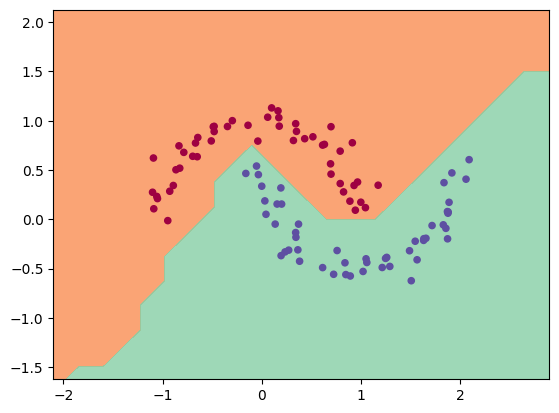

In [104]:
dx = 0.25
x0_min, x0_max = X[:,0].min()-1, X[:,0].max()+1
x1_min, x1_max = X[:,1].min()-1, X[:,1].max()+1

x0, x1 = np.meshgrid(np.arange(x0_min, x0_max, dx), np.arange(x1_min, x1_max, dx))
x_mesh = np.c_[x0.ravel(), x1.ravel()]
score_mesh = map(net, x_mesh)
labels = np.array([s.data>0 for s in score_mesh]).reshape(x0.shape)

plt.contourf(x0, x1, labels, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:,0], X[:,1], s=20, c=y, cmap=plt.cm.Spectral)
plt.xlim(x0.min(), x0.max())
plt.ylim(x1.min(), x1.max())

# labels = [s>0 for s in scores]
